In [51]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [52]:
class YoloMultiLabelDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        """
        Creates a flattened dataset where each bounding box annotation is treated
        as an individual sample.

        Args:
            images_dir (str): Directory containing image files.
            labels_dir (str): Directory containing label files (YOLO format).
            transform (callable, optional): Transformations to apply to each cropped image.
        """
        self.transform = transform
        self.samples = []  # Will store tuples of (img_path, label, x_center, y_center, w, h)
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        
        # List image files (assuming .jpg or .png)
        image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]
        for img_file in image_files:
            img_path = os.path.join(images_dir, img_file)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file)
            if not os.path.exists(label_path):
                continue  # Skip images with no corresponding label file
            
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Each line is a separate annotation; add each as a sample.
            for line in lines:
                parts = line.strip().split()
                # Ensure there are at least 5 tokens: class_id + 4 coordinates
                if len(parts) < 5:
                    continue  # Skip if not enough information
                label = int(parts[0])
                # Map tokens to float and slice to only use the first four values
                values = list(map(float, parts[1:]))
                x_center, y_center, w, h = values[:4]
                self.samples.append((img_path, label, x_center, y_center, w, h))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label, x_center, y_center, w, h = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        width, height = image.size
        
        # Convert normalized coordinates to pixel values
        x_center_abs = x_center * width
        y_center_abs = y_center * height
        w_abs = w * width
        h_abs = h * height
        
        # Calculate bounding box coordinates (left, top, right, bottom)
        x_min = int(x_center_abs - w_abs / 2)
        y_min = int(y_center_abs - h_abs / 2)
        x_max = int(x_center_abs + w_abs / 2)
        y_max = int(y_center_abs + h_abs / 2)
        
        # Ensure the bounding box is within image boundaries
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(width, x_max)
        y_max = min(height, y_max)
        
        # Crop the image to the bounding box
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        
        if self.transform:
            cropped_image = self.transform(cropped_image)
        
        return cropped_image, label


In [53]:
from torchvision import transforms
from torch.utils.data import DataLoader

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_images_dir = 'C:/deep-rod/detection/train/images'
train_labels_dir = 'C:/deep-rod/detection/train/labels'
val_images_dir = 'C:/deep-rod/detection/valid/images'
val_labels_dir = 'C:/deep-rod/detection/valid/labels'

train_dataset = YoloMultiLabelDataset(images_dir=train_images_dir, labels_dir=train_labels_dir, transform=data_transforms)
val_dataset = YoloMultiLabelDataset(images_dir=val_images_dir, labels_dir=val_labels_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [54]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained ResNet18 model
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer for 3 output classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)
        )  # 3 classes: 4-wheels, 6-wheels, 6-more-wheels

model = model.to(device)


c:\Users\ASUS\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
import os

# Define criterion, optimizer, and metrics lists
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10  # Adjust number of epochs as needed

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Check if a saved model exists
model_path = 'car_wheel_classifier.pth'
if os.path.exists(model_path):
    # Load the model instead of training
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model from {model_path}")
else:
    print("Training model from scratch...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Training model from scratch...
Epoch 1/10 - Train Loss: 0.2329 Acc: 0.9151 | Val Loss: 0.0876 Acc: 0.9724
Epoch 2/10 - Train Loss: 0.0700 Acc: 0.9764 | Val Loss: 0.0967 Acc: 0.9672
Epoch 3/10 - Train Loss: 0.0391 Acc: 0.9868 | Val Loss: 0.1329 Acc: 0.9603
Epoch 4/10 - Train Loss: 0.0375 Acc: 0.9864 | Val Loss: 0.1128 Acc: 0.9672
Epoch 5/10 - Train Loss: 0.0236 Acc: 0.9930 | Val Loss: 0.1349 Acc: 0.9638
Epoch 6/10 - Train Loss: 0.0246 Acc: 0.9915 | Val Loss: 0.1369 Acc: 0.9621
Epoch 7/10 - Train Loss: 0.0127 Acc: 0.9957 | Val Loss: 0.1214 Acc: 0.9690
Epoch 8/10 - Train Loss: 0.0302 Acc: 0.9911 | Val Loss: 0.1426 Acc: 0.9586
Epoch 9/10 - Train Loss: 0.0126 Acc: 0.9961 | Val Loss: 0.1647 Acc: 0.9638
Epoch 10/10 - Train Loss: 0.0048 Acc: 0.9988 | Val Loss: 0.1588 Acc: 0.9621


In [56]:
torch.save(model.state_dict(), 'car_wheel_classifier.pth')
print("Model saved as car_wheel_classifier.pth")


Model saved as car_wheel_classifier.pth


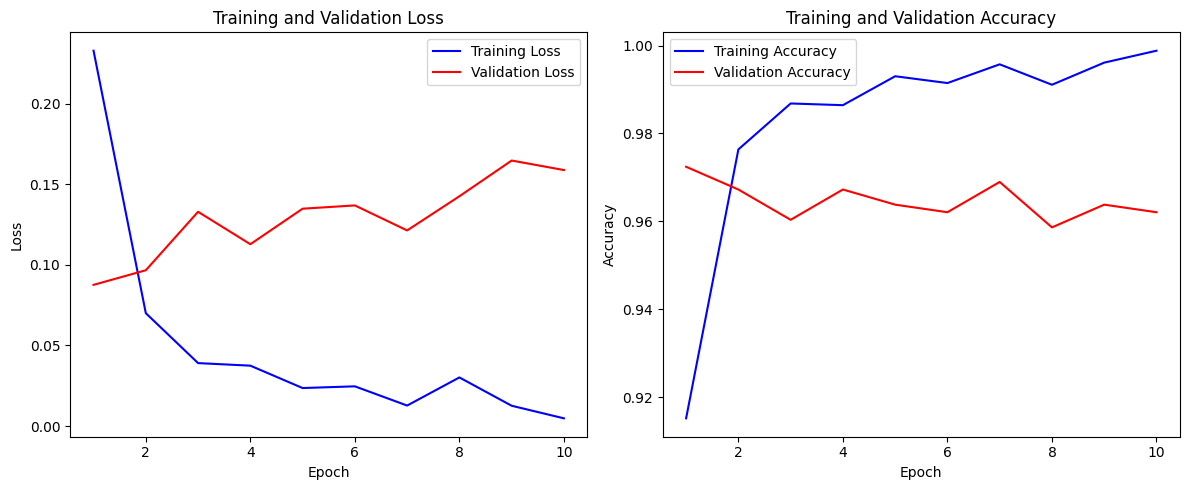

In [57]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label="Training Loss")
plt.plot(epochs, val_losses, 'r-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label="Training Accuracy")
plt.plot(epochs, val_accuracies, 'r-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
def detect_boxes(image, detection_model):
    # Run detection using the YOLO model
    results = detection_model(image)
    bboxes = []
    # Assume results[0] for a single image
    for box in results[0].boxes.xyxy:
        # Each box is a tensor; convert it to a list of ints
        bbox = list(map(int, box.cpu().numpy().tolist()))
        bboxes.append(bbox)
    return bboxes


In [59]:
import matplotlib.patches as patches

# Assuming you have a list of label names
label_names = ['4-wheels', '6-wheels', '6-more-wheels']

def test_image_no_label(image_path, model, transform, device, detection_model=None):
  from PIL import Image
  image = Image.open(image_path).convert("RGB")
  width, height = image.size

  if detection_model is not None:
    bboxes = detect_boxes(image, detection_model)
    # Sort bounding boxes by area (width * height) and select the largest one
    bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
    bboxes = [bboxes[0]]  # Keep only the largest bounding box
  else:
    bboxes = [(0, 0, width, height)]
  
  results = []
  model.eval()
  for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox
    cropped_image = image.crop((x_min, y_min, x_max, y_max))
    if transform:
      cropped_image = transform(cropped_image)
    cropped_image = cropped_image.unsqueeze(0).to(device)
    with torch.no_grad():
      outputs = model(cropped_image)
      _, preds = torch.max(outputs, 1)
      predicted_class = preds.item()
    results.append({
      'predicted_class': predicted_class,
      'bbox': bbox
    })
  
  # Display the image with bounding boxes and predicted classes
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  for result in results:
    bbox = result['bbox']
    predicted_class = result['predicted_class']
    x_min, y_min, x_max, y_max = bbox
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x_min, y_min - 10, f'Class: {label_names[predicted_class]}', color='red', fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.5))
  
  plt.show()
  return results


In [60]:
from ultralytics import YOLO

detection_model = YOLO("yolo12n.pt")

Classification Report:
               precision    recall  f1-score   support

     4-wheels       0.99      0.98      0.99       195
     6-wheels       0.89      0.85      0.87       126
6-more-wheels       0.71      0.81      0.76        63

     accuracy                           0.91       384
    macro avg       0.86      0.88      0.87       384
 weighted avg       0.91      0.91      0.91       384



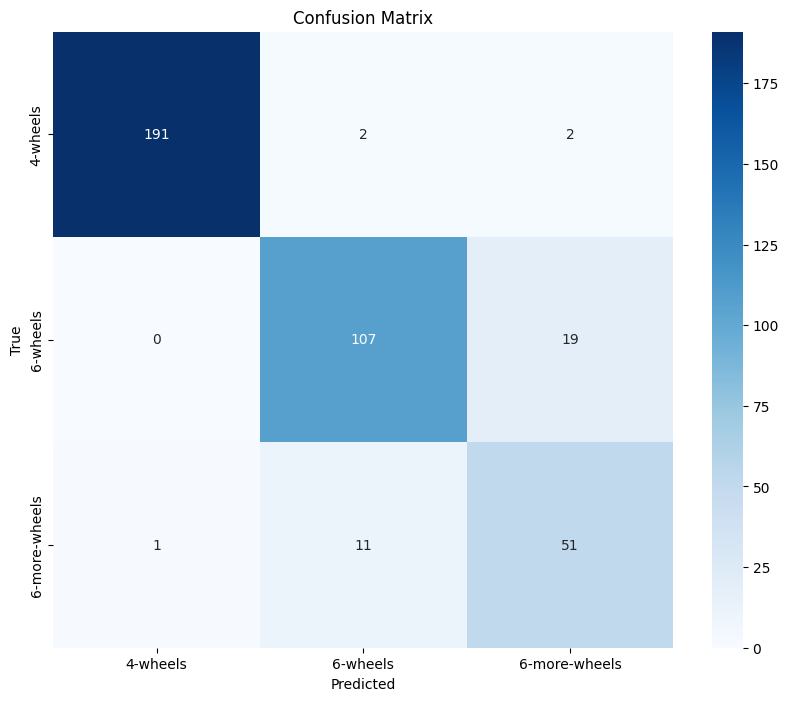

Test Accuracy: 0.9089


In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_performance(model, test_images_dir, test_labels_dir, transform, device, detection_model=None):
  # Create test dataset and dataloader
  test_dataset = YoloMultiLabelDataset(
    images_dir=test_images_dir, 
    labels_dir=test_labels_dir, 
    transform=transform
  )
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
  
  # Set model to evaluation mode
  model.eval()
  
  # Initialize metrics
  correct = 0
  total = 0
  all_preds = []
  all_labels = []
  
  # Evaluate on test set
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      total += labels.size(0)
      correct += (preds == labels).sum().item()
      
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  
  # Calculate accuracy
  accuracy = correct / total
  
  # Import metrics from sklearn
  
  # Generate and print classification report
  class_names = ['4-wheels', '6-wheels', '6-more-wheels']
  print("Classification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))
  
  # Create and plot confusion matrix
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()
  
  return {
    'accuracy': accuracy,
    'predictions': all_preds,
    'true_labels': all_labels
  }

# Path to test data
test_images_dir = 'C:/deep-rod/detection/test/images'
test_labels_dir = 'C:/deep-rod/detection/test/labels'

# Run evaluation
test_results = evaluate_model_performance(model, test_images_dir, test_labels_dir, 
                      data_transforms, device, detection_model)
print(f"Test Accuracy: {test_results['accuracy']:.4f}")

In [62]:
import matplotlib.patches as patches

# Assuming you have a list of label names
label_names = ['4-wheels', '6-wheels', '6-more-wheels']

def test_image_no_label(image_path, model, transform, device, detection_model=None):
  from PIL import Image
  image = Image.open(image_path).convert("RGB")
  width, height = image.size

  if detection_model is not None:
    bboxes = detect_boxes(image, detection_model)
    # Sort bounding boxes by area (width * height) and select the largest one
    bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
    bboxes = [bboxes[0]]  # Keep only the largest bounding box
  else:
    bboxes = [(0, 0, width, height)]
  
  results = []
  model.eval()
  for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox
    cropped_image = image.crop((x_min, y_min, x_max, y_max))
    if transform:
      cropped_image = transform(cropped_image)
    cropped_image = cropped_image.unsqueeze(0).to(device)
    with torch.no_grad():
      outputs = model(cropped_image)
      _, preds = torch.max(outputs, 1)
      predicted_class = preds.item()
    results.append({
      'predicted_class': predicted_class,
      'bbox': bbox
    })
  
  # Display the image with bounding boxes and predicted classes
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  for result in results:
    bbox = result['bbox']
    predicted_class = result['predicted_class']
    x_min, y_min, x_max, y_max = bbox
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x_min, y_min - 10, f'Class: {label_names[predicted_class]}', color='red', fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.5))
  
  plt.show()
  return results


0: 640x480 1 truck, 29.0ms
Speed: 6.7ms preprocess, 29.0ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


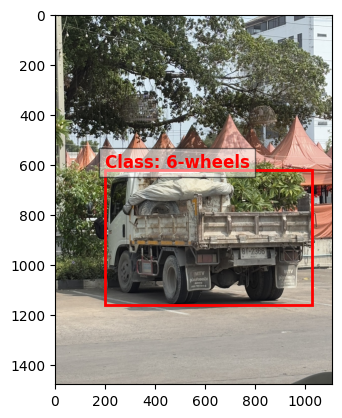

[{'predicted_class': 1, 'bbox': [199, 619, 1028, 1158]}]


In [63]:
image_path = 'car-8.jpg'
predictions = test_image_no_label(image_path, model, data_transforms, device, detection_model=detection_model)
print(predictions)

In [66]:
import cv2
import time
import numpy as np
from PIL import Image
import torch

def process_video(source=0, detection_model=detection_model, classification_model=model, transform=data_transforms):
  """
  Real-time video detection and classification using YOLO and ResNet model.
  
  Args:
    source: Camera index or video file path (0 for webcam)
    detection_model: YOLO model for detection
    classification_model: ResNet model for classification
    transform: Image transformations for the classification model
  """
  # Open video capture
  cap = cv2.VideoCapture(source)
  if not cap.isOpened():
    print(f"Error: Could not open video source {source}")
    return
  
  # Get video properties
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = cap.get(cv2.CAP_PROP_FPS)
  
  # Set classification model to evaluation mode
  classification_model.eval()
  
  # Start processing loop
  while True:
    # Read frame
    ret, frame = cap.read()
    if not ret:
      print("End of video stream")
      break
    
    # Convert to RGB for YOLO (which expects RGB)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)
    
    # Process with YOLO detection model
    start_time = time.time()
    results = detection_model(pil_image)
    
    # Get bounding boxes
    bboxes = []
    for box in results[0].boxes.xyxy:
      bbox = list(map(int, box.cpu().numpy().tolist()))
      bboxes.append(bbox)
    
    # Sort bounding boxes by area and keep only the largest one
    if bboxes:
      bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
      bboxes = [bboxes[0]]  # Keep only the largest bounding box
    
    # Process each detection (now only one or none)
    for bbox in bboxes:
      x_min, y_min, x_max, y_max = bbox
      
      # Crop the image to the bounding box
      cropped_pil = pil_image.crop((x_min, y_min, x_max, y_max))
      
      # Apply transform and classify
      if transform:
        input_tensor = transform(cropped_pil).unsqueeze(0).to(device)
        with torch.no_grad():
          outputs = classification_model(input_tensor)
          _, preds = torch.max(outputs, 1)
          predicted_class = preds.item()
      
      # Draw bounding box and class label
      color = (0, 255, 0)  # Green
      cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)
      
      # Put text with class prediction
      class_name = label_names[predicted_class]
      label = f"Class: {class_name}"
      cv2.putText(frame, label, (x_min, y_min - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Calculate FPS
    process_time = time.time() - start_time
    fps_text = f"FPS: {1/process_time:.2f}"
    cv2.putText(frame, fps_text, (10, 30), 
          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Show the frame
    cv2.imshow('Vehicle Detection and Classification', frame)
    
    # Break loop with 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  
  # Release resources
  cap.release()
  cv2.destroyAllWindows()

# Call the function - use 0 for webcam or a file path for a video file
process_video("car-video.mp4")  # Uncomment this line to run with webcam


0: 384x640 1 car, 1 tennis racket, 51.4ms
Speed: 7.5ms preprocess, 51.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 tennis racket, 46.8ms
Speed: 4.2ms preprocess, 46.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tennis racket, 51.1ms
Speed: 6.4ms preprocess, 51.1ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.3ms
Speed: 3.4ms preprocess, 23.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 23.4ms
Speed: 6.3ms preprocess, 23.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 24.8ms
Speed: 4.2ms preprocess, 24.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 23.2ms
Speed: 3.1ms preprocess, 23.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 29.5ms
Speed: 3.9ms preprocess, 29.5ms inference, 2.8ms postpr

KeyboardInterrupt: 